In [11]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [12]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words = [word.lower() for word in words] # convert to lower case
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

9827
19
['aabid', 'aabida', 'aachal', 'aadesh', 'aadil', 'aadish', 'aaditya', 'aaenab']


In [13]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [14]:
# shuffle up the words
import random
random.seed(128847)
random.shuffle(words)

In [15]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(128847)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([58288, 8]) torch.Size([58288])
torch.Size([7207, 8]) torch.Size([7207])
torch.Size([7204, 8]) torch.Size([7204])


In [16]:
for x,y in zip(Xtr[:20], Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> t
.......t --> u
......tu --> f
.....tuf --> a
....tufa --> i
...tufai --> l
..tufail --> .
........ --> s
.......s --> u
......su --> c
.....suc --> h
....such --> e
...suche --> t
..suchet --> a
.sucheta --> .
........ --> d
.......d --> h
......dh --> a
.....dha --> r
....dhar --> v


In [18]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []
  
# --------------------------------------------------------------------------------------------------------------------------
class Embedding:

  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim)) 
  
  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out
  
  def parameters(self):
    return []
  
# --------------------------------------------------------------------------------------------------------------------------
class Flaten:
  def __call__(self, x):
    self.out = x.view(x.shape[0], -1)
    return self.out
  
  def parameters(self):
    return []
  
# --------------------------------------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  
  def parameters(self):
    # get the parameters from all layers and stream them out into one list
    return [param for layer in self.layers for param in layer.parameters()]

In [19]:
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

model = Sequential([
  Embedding(vocab_size, n_embd),
  Flaten(),
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size,),
])


#parameter init
with torch.no_grad():
  model.layers[-1].weight *= 0.1 # last layer weights made less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

10927


In [11]:
# same optimization as last time
max_steps = 50000
batch_size = 32
lossi = []
# ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  # with torch.no_grad():
  #   ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  # break

      0/  50000: 3.3147
  10000/  50000: 1.8938
  20000/  50000: 1.8717
  30000/  50000: 1.7968
  40000/  50000: 2.0341


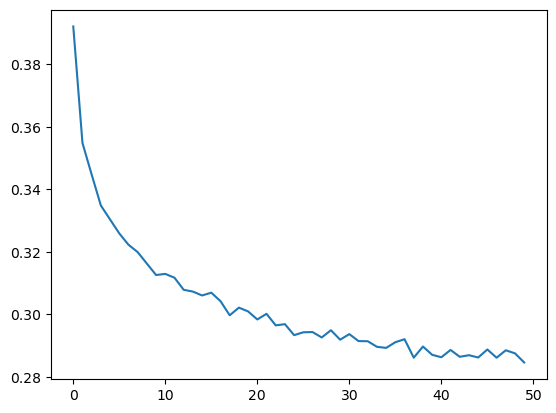

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [20]:
# put layers in eval mode
for layer in model.layers:
  layer.training = False 

In [21]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x,y ={
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    x = model(x)
    loss = F.cross_entropy(x, y)
    print(f'{split} loss: {loss.item():.4f}')

split_loss('train')
split_loss('val')

train loss: 3.3031
val loss: 3.3024


##### Performance Log
* Original (3 character context + 100 hidden neurons + 5.2k parmas) | train loss: 2.0223 | val loss: 2.1352
* Character context: 3->8, (3.2k parmas) | train loss: 1.6534 | val loss: 2.3717

In [27]:
# sample from the model
for _ in range(1):
  
    out = []
    context = [0] * block_size
  
    while True:
        # forward pass neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)

        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()

        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)

        # if we sample . (end of word), stop
        if ix == 0:
            break

    print(''.join(itos[ix] for ix in out))

tensor([[-0.0298, -0.1335, -0.0200,  0.0577, -0.0488, -0.1105, -0.0185,  0.0986,
          0.0848, -0.0793, -0.0508, -0.0983,  0.1001,  0.1040,  0.0849,  0.1644,
         -0.0350, -0.0341,  0.0977,  0.0208,  0.0067, -0.0443, -0.0926,  0.0903,
         -0.1625,  0.0686,  0.0570]], grad_fn=<AddBackward0>)
